In [1]:
!pip install skforecast lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import traceback
import os
from tqdm import tqdm
from os import path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error
import skforecast
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/final_variables.zip", "r") as zip_file:
    # Extract all contents
    zip_file.extractall()

In [4]:
df = pd.read_csv('/content/final_variables/-10_10_100_120_49.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
df.head()

sea_level  temperature  precipitation  relative_humidity  \
2002-04-01  -0.007504     0.341324       6.086234          82.212124   
2002-05-01   0.034153     0.367918       4.980250          80.664751   
2002-06-01   0.020669     0.284284       5.307215          80.178718   
2002-07-01   0.004759     0.317057       3.011250          79.029472   
2002-08-01  -0.010802     0.066045       3.754239          76.767973   

                clwc  liquid_water_thickness  eddy_kinetic_energy  month  \
2002-04-01  0.000003                0.633437           513.024359      4   
2002-05-01  0.000004                1.064181           633.271034      5   
2002-06-01  0.000003               -0.905211           552.547121      6   
2002-07-01  0.000002               -2.874602           686.659017      7   
2002-08-01  0.000001               -4.843994           673.215839      8   

            year  quarter  month_sin     month_cos   quarter_sin   quarter_cos  
2002-04-01  2002        2   0.866025  5.000000e-01  1.224647e-16 -1.000000e+00  
2002-05-01  2002        2   0.965926  2.588190e-01  1.224647e-16 -1.000000e+00  
2002-06-01  2002        2   1.000000  6.123234e-17  1.224647e-16 -1.000000e+00  
2002-07-01  2002        3   0.965926 -2.588190e-01 -1.000000e+00 -1.836970e-16  
2002-08-01  2002        3   0.866025 -5.000000e-01 -1.000000e+00 -1.836970e-16

In [5]:
climate_vars = ['liquid_water_thickness', 'temperature', 'precipitation', 'relative_humidity', 'clwc', 'sea_level', 'eddy_kinetic_energy']
data = df[climate_vars]

df_data = df.copy()
exog_data = df_data.drop(climate_vars, axis=1)


In [ ]:
end_train = '2018-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}"
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}"
    f"(n={len(data_test)})"
)

Train dates : 2002-04-01 00:00:00 --- 2018-01-01 00:00:00(n=190)
Test dates  : 2018-01-01 00:00:00 --- 2028-08-01 00:00:00(n=128)


In [ ]:
exog_train = exog_data.loc[:end_train, :].copy()
exog_test  = exog_data.loc[end_train:, :].copy()

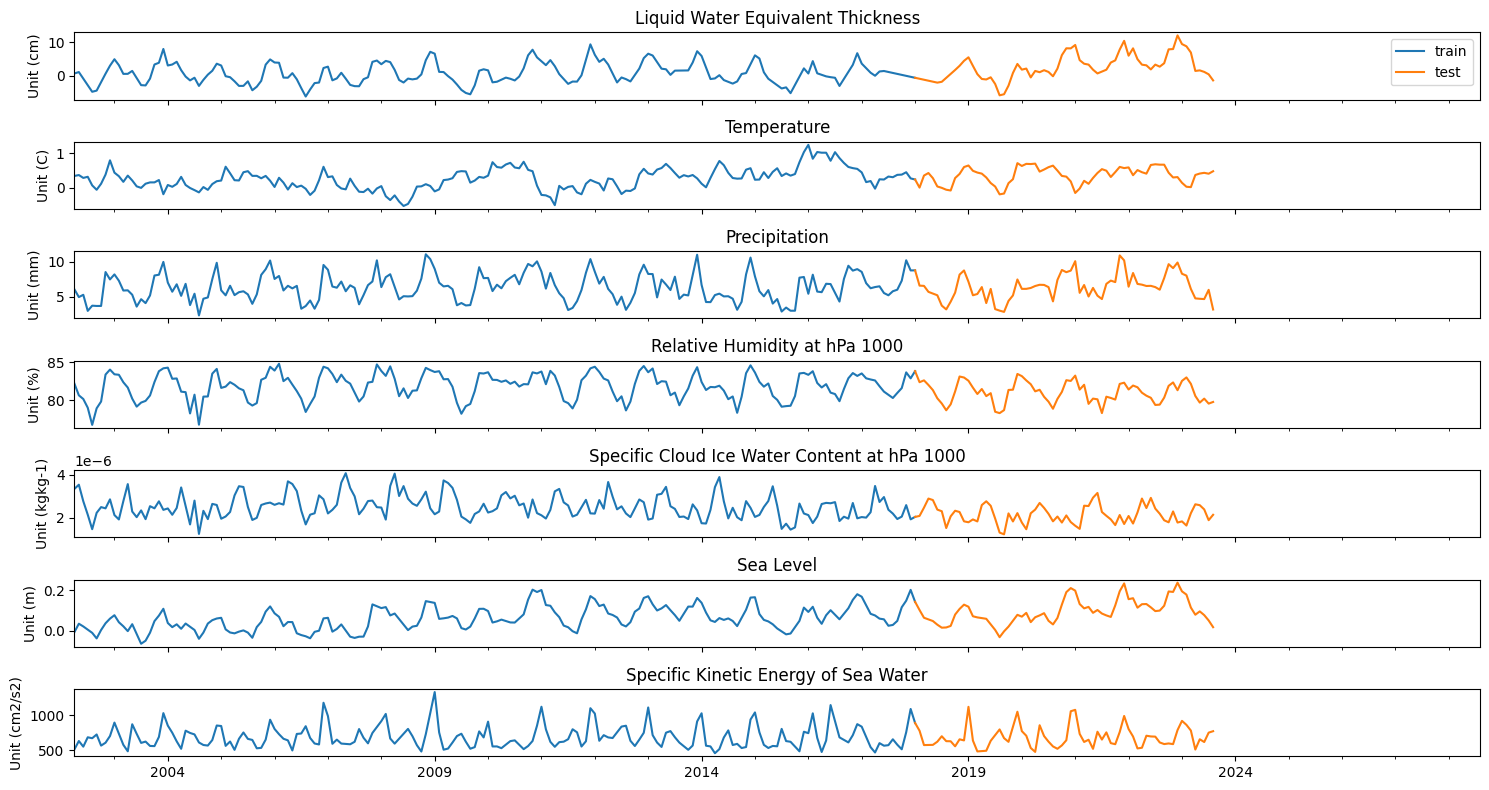

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 8), sharex=True)

data_train['liquid_water_thickness'].plot(label='train', ax=axes[0])
data_test['liquid_water_thickness'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Unit (cm)')
axes[0].set_title('Liquid Water Equivalent Thickness')
axes[0].legend()

data_train['temperature'].plot(label='train', ax=axes[1])
data_test['temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Unit (C)')
axes[1].set_title('Temperature')

data_train['precipitation'].plot(label='train', ax=axes[2])
data_test['precipitation'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('Unit (mm)')
axes[2].set_title('Precipitation')

data_train['relative_humidity'].plot(label='train', ax=axes[3])
data_test['relative_humidity'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('')
axes[3].set_ylabel('Unit (%)')
axes[3].set_title('Relative Humidity at hPa 1000')

data_train['clwc'].plot(label='train', ax=axes[4])
data_test['clwc'].plot(label='test', ax=axes[4])
axes[4].set_xlabel('')
axes[4].set_ylabel('Unit (kgkg-1)')
axes[4].set_title('Specific Cloud Ice Water Content at hPa 1000')

data_train['sea_level'].plot(label='train', ax=axes[5])
data_test['sea_level'].plot(label='test', ax=axes[5])
axes[5].set_xlabel('')
axes[5].set_ylabel('Unit (m)')
axes[5].set_title('Sea Level')

data_train['eddy_kinetic_energy'].plot(label='train', ax=axes[6])
data_test['eddy_kinetic_energy'].plot(label='test', ax=axes[6])
axes[6].set_xlabel('')
axes[6].set_ylabel('Unit (cm2/s2)')
axes[6].set_title('Specific Kinetic Energy of Sea Water')

fig.tight_layout()
plt.show();

## Process All the Grids

In [7]:
# one-hot encoding
categorical_features = []
transformer_exog = make_column_transformer(
    (
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        categorical_features
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")


def search_space(trial):

  # Lags grid
  lags_grid = tuple([12, 24, [1, 2, 3, 4, 7, 9, 24]])

  search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
  return search_space


In [8]:
def search_hyperparameters(data, end_train, end_valid, series_vars, exog_features,transformer_exog):

  # Bayesian search hyperparameters and lags with Optuna
  forecaster = ForecasterAutoregMultiVariate(
                    regressor = LGBMRegressor(random_state=15926, verbose=-1),
                    lags = 24,
                    steps = 24,
                    level = 'liquid_water_thickness',
                    transformer_series = StandardScaler(),
                    transformer_exog = transformer_exog,
                    fit_kwargs       = {"categorical_feature": "auto"},
                    weight_func        = None,
                    n_jobs             = 'auto'
              )

  results, _ = bayesian_search_forecaster_multiseries(
                          forecaster            = forecaster,
                          series                = data.loc[:end_valid, series_vars],
                          exog                  = data.loc[:end_valid, exog_features],
                          search_space          = search_space,
                          steps                 = 24,
                          metric                = 'mean_absolute_percentage_error',
                          aggregate_metric      = 'weighted_average',
                          refit                 = False,
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          n_trials              = 5,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )
  best_params = results['params'].iat[0]

  return best_params


In [16]:
from sklearn.metrics import mean_squared_error
def rmsse(y_true, y_pred):
    # Calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)

    # Calculate the standard deviation of the true values
    std_true = np.std(y_true)

    # Scale the MSE by the standard deviation
    rmsse = np.sqrt(mse * std_true)

    return rmsse

In [11]:
def train_and_predict(data, best_params, actual_data, end_valid, end_train, valid_num, train_num, df_idx, series_vars, exog_features, transformer_exog):

  # train for evaluation of the model
  forecaster = ForecasterAutoregMultiVariate(
                  regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
                  lags = 24,
                  steps = 24,
                  level = 'liquid_water_thickness',
                  transformer_series = StandardScaler(),
                  transformer_exog = transformer_exog,
                  fit_kwargs       = {"categorical_feature": "auto"},
                  weight_func        = None,
                  n_jobs             = 'auto'
             )
  forecaster.fit(
      series=data.loc[:end_train, series_vars],
      exog=data.loc[:end_train, exog_features])

  # make predictions and evalute the model
  predictions = forecaster.predict(
    exog     = data.loc[df_idx[train_num+1]:, exog_features]
  )

  df_preds = pd.DataFrame(predictions)
  preds = df_preds["liquid_water_thickness"].values

  # evaluate on root mean scaled error
  rmsse_value = rmsse(actual_data, preds)

  # train for future predictions
  forecaster = ForecasterAutoregMultiVariate(
                  regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
                  lags = 24,
                  steps = 60,
                  level = 'liquid_water_thickness',
                  transformer_series = StandardScaler(),
                  transformer_exog = transformer_exog,
                  fit_kwargs       = {"categorical_feature": "auto"},
                  weight_func        = None,
                  n_jobs             = 'auto'
             )

  forecaster.fit(
      series=data.loc[:end_valid, series_vars],
      exog=data.loc[:end_valid, exog_features])

  # Predict for 5 years into the future
  predictions = forecaster.predict(
    exog     = data.loc[df_idx[valid_num+1]:, exog_features]
  )
  df_preds = pd.DataFrame(predictions)

  importance = forecaster.get_feature_importances(step=60)

  return df_preds,rmsse_value, importance[:10]


In [12]:
def populate_test_data(data_dir):

  preds_dict = {}
  important_features = []
  rmsse_total = 0.0

  # collect all files in the directory
  filenames = os.listdir(data_dir)

  try:

    for filename in tqdm(filenames):

        grid = filename.split(".")[0].split("-")[-1]
        filepath = path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        #df["season"] = df["season"].astype("category")
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        df.index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

        # get the estimate end train and end validation dates
        data = df.copy()
        series = climate_vars
        exog_data = data.drop(series, axis=1)
        exog_features = exog_data.columns
        df_idx = data.index
        train_num = int(len(data.loc[: df_idx[-62]]) * 0.8)
        valid_num = len(data.loc[: df_idx[-62]])
        end_train = df_idx[train_num]
        end_valid = df_idx[valid_num]
        end_evaluation = df_idx[train_num+24]
        evaluate_data = data.loc[df_idx[train_num+1]: end_evaluation, 'liquid_water_thickness'].values


        # tune for best hyperparamters and evaluate on MAPE metric
        best_params = search_hyperparameters(data, end_train, end_valid, series, exog_features, transformer_exog)

        # train and make predict for 5 years
        df_predictions, rmsse, important = train_and_predict(data,best_params, evaluate_data, end_valid, end_train, valid_num, train_num, df_idx, series, exog_features, transformer_exog)
        df_predictions["pred"] =  df_predictions["liquid_water_thickness"].round(2)
        preds_dict[grid] = df_predictions['pred'].values
        important_features.append(important)
        rmsse_total += rmsse

  except Exception as ex:
    print("[Error]")
    print(traceback.format_exc())

  overall_rmsse = rmsse_total / float(len(filenames))
  df_final_preds = pd.DataFrame(preds_dict, index=range(60))
  df_final_preds.index = pd.date_range(start=pd.Timestamp("2023-08-01") + pd.DateOffset(months=1), periods=60, freq='MS')

  print("> Done")

  return df_final_preds, rmsse, important_features


### Features Importance at step 60 (2028-12-01)

In [ ]:
data_dir = "/content/final_variables"

df_submission, rmsse, important_features = populate_test_data(data_dir)

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|          | 1/151 [00:32<1:20:45, 32.31s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|▏         | 2/151 [01:01<1:16:22, 30.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  2%|▏         | 3/151 [01:34<1:18:13, 31.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  3%|▎         | 4/151 [02:03<1:15:10, 30.68s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  3%|▎         | 5/151 [02:34<1:14:34, 30.65s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  4%|▍         | 6/151 [02:40<53:29, 22.13s/it]  

  0%|          | 0/5 [00:00<?, ?it/s]

  5%|▍         | 7/151 [03:08<58:23, 24.33s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  5%|▌         | 8/151 [03:15<44:50, 18.81s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  6%|▌         | 9/151 [03:43<50:51, 21.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 10/151 [04:14<57:37, 24.52s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 11/151 [04:20<43:40, 18.72s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  8%|▊         | 12/151 [04:26<34:41, 14.98s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▊         | 13/151 [04:33<28:29, 12.39s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▉         | 14/151 [04:38<23:38, 10.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 10%|▉         | 15/151 [04:46<21:24,  9.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 11%|█         | 16/151 [04:51<18:45,  8.34s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 11%|█▏        | 17/151 [05:21<32:36, 14.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 12%|█▏        | 18/151 [05:28<27:20, 12.33s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 13%|█▎        | 19/151 [05:33<22:46, 10.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 13%|█▎        | 20/151 [05:41<20:36,  9.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 14%|█▍        | 21/151 [06:12<34:28, 15.91s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▍        | 22/151 [06:43<43:55, 20.43s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▌        | 23/151 [07:14<50:29, 23.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 16%|█▌        | 24/151 [07:45<55:02, 26.00s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 25/151 [08:17<57:58, 27.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 26/151 [08:50<1:01:16, 29.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 18%|█▊        | 27/151 [08:56<46:05, 22.30s/it]  

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▊        | 28/151 [09:27<51:12, 24.98s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▉        | 29/151 [09:35<40:09, 19.75s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|█▉        | 30/151 [09:40<31:19, 15.54s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 21%|██        | 31/151 [10:12<40:40, 20.33s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 21%|██        | 32/151 [10:19<32:38, 16.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 22%|██▏       | 33/151 [10:25<26:05, 13.27s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 34/151 [10:32<22:17, 11.43s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 35/151 [11:01<32:10, 16.64s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 24%|██▍       | 36/151 [11:32<39:56, 20.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▍       | 37/151 [12:03<45:21, 23.88s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▌       | 38/151 [12:33<48:23, 25.70s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 26%|██▌       | 39/151 [12:39<37:06, 19.88s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 26%|██▋       | 40/151 [12:46<29:27, 15.92s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 27%|██▋       | 41/151 [13:16<37:03, 20.21s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 42/151 [13:45<41:46, 22.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 43/151 [13:51<32:15, 17.92s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 29%|██▉       | 44/151 [14:23<39:09, 21.96s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|██▉       | 45/151 [14:29<30:19, 17.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|███       | 46/151 [14:35<24:12, 13.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 31%|███       | 47/151 [15:04<32:01, 18.47s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 32%|███▏      | 48/151 [15:36<38:25, 22.38s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 32%|███▏      | 49/151 [16:03<40:27, 23.80s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 33%|███▎      | 50/151 [16:10<31:28, 18.70s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 34%|███▍      | 51/151 [16:41<37:33, 22.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 34%|███▍      | 52/151 [16:48<29:23, 17.81s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 35%|███▌      | 53/151 [16:54<23:21, 14.30s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▌      | 54/151 [17:00<19:10, 11.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▋      | 55/151 [17:33<29:03, 18.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 37%|███▋      | 56/151 [18:04<34:53, 22.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 57/151 [18:35<38:39, 24.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 58/151 [18:41<29:30, 19.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 39%|███▉      | 59/151 [19:12<34:54, 22.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|███▉      | 60/151 [19:18<26:58, 17.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 61/151 [19:25<21:25, 14.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 41%|████      | 62/151 [19:52<27:06, 18.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 42%|████▏     | 63/151 [20:24<32:57, 22.48s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 42%|████▏     | 64/151 [20:31<25:39, 17.69s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 43%|████▎     | 65/151 [20:37<20:28, 14.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▎     | 66/151 [21:05<25:59, 18.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▍     | 67/151 [21:13<21:07, 15.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 45%|████▌     | 68/151 [21:44<27:45, 20.07s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▌     | 69/151 [21:51<21:56, 16.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▋     | 70/151 [21:58<17:56, 13.29s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 47%|████▋     | 71/151 [22:30<25:05, 18.82s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 72/151 [22:37<20:15, 15.38s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 73/151 [23:07<25:35, 19.69s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 49%|████▉     | 74/151 [23:38<29:40, 23.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 50%|████▉     | 75/151 [23:44<22:43, 17.94s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 50%|█████     | 76/151 [23:51<18:29, 14.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 51%|█████     | 77/151 [24:21<23:58, 19.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 78/151 [24:27<18:40, 15.36s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 79/151 [24:59<24:16, 20.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 53%|█████▎    | 80/151 [25:32<28:24, 24.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▎    | 81/151 [26:03<30:30, 26.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▍    | 82/151 [26:35<32:07, 27.93s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 55%|█████▍    | 83/151 [27:06<32:46, 28.92s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▌    | 84/151 [27:38<33:13, 29.76s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▋    | 85/151 [28:10<33:29, 30.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 57%|█████▋    | 86/151 [28:17<25:24, 23.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 58%|█████▊    | 87/151 [28:49<27:39, 25.92s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 58%|█████▊    | 88/151 [29:19<28:46, 27.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 59%|█████▉    | 89/151 [29:52<29:53, 28.92s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|█████▉    | 90/151 [29:59<22:41, 22.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 91/151 [30:05<17:20, 17.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 61%|██████    | 92/151 [30:12<14:08, 14.38s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 93/151 [30:18<11:26, 11.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 94/151 [30:47<16:11, 17.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 63%|██████▎   | 95/151 [31:18<19:53, 21.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▎   | 96/151 [31:51<22:38, 24.70s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▍   | 97/151 [31:57<17:11, 19.11s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 65%|██████▍   | 98/151 [32:04<13:35, 15.38s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 66%|██████▌   | 99/151 [32:11<11:04, 12.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 66%|██████▌   | 100/151 [32:42<15:36, 18.36s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 67%|██████▋   | 101/151 [32:49<12:33, 15.07s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 68%|██████▊   | 102/151 [33:21<16:23, 20.07s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 68%|██████▊   | 103/151 [33:27<12:40, 15.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 69%|██████▉   | 104/151 [33:35<10:27, 13.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|██████▉   | 105/151 [34:03<13:45, 17.95s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|███████   | 106/151 [34:09<10:44, 14.33s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 71%|███████   | 107/151 [34:41<14:17, 19.48s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 108/151 [35:12<16:31, 23.07s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 109/151 [35:44<18:06, 25.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 73%|███████▎  | 110/151 [36:15<18:43, 27.41s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 74%|███████▎  | 111/151 [36:21<13:58, 20.95s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 74%|███████▍  | 112/151 [36:29<10:59, 16.91s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▍  | 113/151 [37:00<13:23, 21.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▌  | 114/151 [37:30<14:47, 23.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 76%|███████▌  | 115/151 [37:36<11:08, 18.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 116/151 [38:09<13:20, 22.86s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 117/151 [38:15<10:05, 17.80s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 78%|███████▊  | 118/151 [38:47<12:05, 22.00s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 79%|███████▉  | 119/151 [38:55<09:25, 17.68s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 79%|███████▉  | 120/151 [39:25<11:09, 21.61s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 121/151 [39:57<12:18, 24.63s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████  | 122/151 [40:04<09:16, 19.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████▏ | 123/151 [40:10<07:12, 15.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 82%|████████▏ | 124/151 [40:42<09:05, 20.21s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 125/151 [40:49<07:02, 16.24s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 126/151 [41:19<08:30, 20.43s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 84%|████████▍ | 127/151 [41:51<09:33, 23.89s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▍ | 128/151 [42:22<09:59, 26.07s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▌ | 129/151 [42:28<07:23, 20.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 86%|████████▌ | 130/151 [42:35<05:41, 16.24s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 87%|████████▋ | 131/151 [42:41<04:21, 13.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 87%|████████▋ | 132/151 [42:48<03:35, 11.34s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 88%|████████▊ | 133/151 [43:19<05:09, 17.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 89%|████████▊ | 134/151 [43:50<06:03, 21.39s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 89%|████████▉ | 135/151 [44:21<06:28, 24.27s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 90%|█████████ | 136/151 [44:53<06:36, 26.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████ | 137/151 [44:59<04:45, 20.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████▏| 138/151 [45:05<03:27, 15.98s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 92%|█████████▏| 139/151 [45:36<04:07, 20.60s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 140/151 [46:08<04:23, 23.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 141/151 [46:14<03:04, 18.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 94%|█████████▍| 142/151 [46:44<03:17, 21.96s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 95%|█████████▍| 143/151 [47:14<03:16, 24.56s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 95%|█████████▌| 144/151 [47:22<02:15, 19.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 96%|█████████▌| 145/151 [47:27<01:31, 15.25s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 97%|█████████▋| 146/151 [47:35<01:04, 12.90s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 97%|█████████▋| 147/151 [47:40<00:42, 10.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 98%|█████████▊| 148/151 [48:09<00:48, 16.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print(f"Root Mean Squared Scaled Error: {rmsse}")

Root Mean Squared Scaled Error: 2.9148283752986557


In [18]:
df_submission

30_320_340_146  70_340_360_153  30_50_140_160_69  \
2023-09-01            3.42           20.43              3.52   
2023-10-01            2.91           20.12              4.55   
2023-11-01            2.99           20.79              4.75   
2023-12-01            2.78           20.36              4.42   
2024-01-01            2.94           19.68              3.46   
2024-02-01            2.96           18.20              3.50   
2024-03-01            2.84           18.22              3.72   
2024-04-01            3.56           19.67              2.87   
2024-05-01            2.96           19.89              3.12   
2024-06-01            2.85           19.15              4.07   
2024-07-01            2.75           19.52              5.23   
2024-08-01            3.50           19.17              5.12   
2024-09-01            3.18           19.87              4.45   
2024-10-01            3.92           19.77              4.66   
2024-11-01            3.53           21.92              5.09   
2024-12-01            3.95           20.24              3.89   
2025-01-01            3.43           19.62              3.28   
2025-02-01            4.34           18.33              3.95   
2025-03-01            4.63           18.66              4.88   
2025-04-01            3.87           19.65              4.85   
2025-05-01            3.52           18.30              4.59   
2025-06-01            3.98           17.49              5.35   
2025-07-01            3.45           18.89              5.71   
2025-08-01            3.11           19.48              6.08   
2025-09-01            3.60           19.51              7.20   
2025-10-01            4.20           19.77              7.10   
2025-11-01            4.48           20.24              6.22   
2025-12-01            3.85           19.44              5.21   
2026-01-01            3.62           20.68              5.91   
2026-02-01            5.02           20.54              4.11   
2026-03-01            4.64           19.86              4.25   
2026-04-01            3.61           20.05              5.57   
2026-05-01            4.33           20.92              5.66   
2026-06-01            4.34           20.72              5.97   
2026-07-01            4.88           23.83              6.79   
2026-08-01            4.29           23.66              5.99   
2026-09-01            4.42           22.72              6.55   
2026-10-01            4.58           22.17              7.01   
2026-11-01            5.34           22.41              6.98   
2026-12-01            5.25           24.08              6.94   
2027-01-01            4.55           23.33              5.57   
2027-02-01            4.54           23.96              6.16   
2027-03-01            4.67           22.24              7.30   
2027-04-01            4.80           22.95              6.76   
2027-05-01            4.27           22.05              6.26   
2027-06-01            4.85           23.20              6.57   
2027-07-01            4.92           23.33              6.24   
2027-08-01            5.28           23.96              7.79   
2027-09-01            4.90           23.21              7.74   
2027-10-01            6.12           23.14              6.83   
2027-11-01            5.71           25.58              7.11   
2027-12-01            5.19           25.93              6.07   
2028-01-01            5.58           23.27              5.43   
2028-02-01            4.20           24.55              5.56   
2028-03-01            4.67           25.19              6.35   
2028-04-01            4.11           23.29              7.54   
2028-05-01            4.02           23.31              6.53   
2028-06-01            3.90           22.72              5.97   
2028-07-01            5.73           24.04              6.73   
2028-08-01            5.68           23.64              5.01   

            50_70_200_220_97  10_10_80_100_40  30_50_320_340_150  70_20_40_9  \
2023-09-01            -14.9

In [ ]:
features = pd.concat(important_features)

In [ ]:
feat = features.groupby("feature")["importance"].sum().sort_values(ascending=False)[:30].reset_index()
feat

feature  importance
0              temperature_lag_8         397
1                sea_level_lag_1         348
2     eddy_kinetic_energy_lag_22         341
3             temperature_lag_20         330
4       relative_humidity_lag_13         324
5       relative_humidity_lag_22         300
6   liquid_water_thickness_lag_1         293
7     eddy_kinetic_energy_lag_20         283
8        relative_humidity_lag_1         283
9                    clwc_lag_13         279
10                   clwc_lag_21         279
11          precipitation_lag_22         278
12                   clwc_lag_23         277
13       relative_humidity_lag_9         275
14          precipitation_lag_18         273
15      relative_humidity_lag_16         262
16             temperature_lag_4         261
17            temperature_lag_24         258
18      relative_humidity_lag_19         255
19                    clwc_lag_4         255
20     eddy_kinetic_energy_lag_9         253
21           precipitation_lag_8         251
22      relative_humidity_lag_14         246
23              sea_level_lag_12         246
24          precipitation_lag_24         246
25               sea_level_lag_3         244
26       relative_humidity_lag_2         244
27                   clwc_lag_16         244
28            temperature_lag_11         242
29             temperature_lag_7         238

In [ ]:
import re
feat["feature"] = feat["feature"].str.replace(r'_lag.*', '', regex=True)
feat.groupby("feature")["importance"].sum().sort_values(ascending=False)

feature
relative_humidity         2189
temperature               1726
clwc                      1334
precipitation             1048
eddy_kinetic_energy        877
sea_level                  838
liquid_water_thickness     293
Name: importance, dtype: int32

### Features Importance at step 1 (2024-01-01)

In [ ]:
data_dir = "/content/final_variables"

df_submission, rmsse, important_features = populate_test_data(data_dir)

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|          | 1/151 [00:33<1:23:17, 33.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  1%|▏         | 2/151 [00:41<45:23, 18.28s/it]  

  0%|          | 0/5 [00:00<?, ?it/s]

  2%|▏         | 3/151 [00:52<36:56, 14.98s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  3%|▎         | 4/151 [00:58<28:23, 11.59s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  3%|▎         | 5/151 [01:05<23:58,  9.85s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  4%|▍         | 6/151 [01:34<39:36, 16.39s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  5%|▍         | 7/151 [01:41<31:58, 13.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  5%|▌         | 8/151 [01:47<26:23, 11.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  6%|▌         | 9/151 [02:20<42:11, 17.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 10/151 [02:51<51:13, 21.80s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  7%|▋         | 11/151 [03:25<59:34, 25.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  8%|▊         | 12/151 [03:31<45:42, 19.73s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▊         | 13/151 [04:11<59:22, 25.81s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

  9%|▉         | 14/151 [04:18<46:07, 20.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 10%|▉         | 15/151 [04:25<36:33, 16.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 11%|█         | 16/151 [05:00<49:09, 21.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 11%|█▏        | 17/151 [05:33<56:37, 25.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 12%|█▏        | 18/151 [05:40<43:31, 19.64s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 13%|█▎        | 19/151 [05:46<34:44, 15.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 13%|█▎        | 20/151 [05:53<28:38, 13.11s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 14%|█▍        | 21/151 [06:00<23:59, 11.07s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▍        | 22/151 [06:34<38:30, 17.91s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▌        | 23/151 [07:05<47:11, 22.12s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 16%|█▌        | 24/151 [07:40<54:29, 25.75s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 25/151 [08:10<56:54, 27.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 26/151 [08:43<1:00:21, 28.97s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 18%|█▊        | 27/151 [08:50<46:09, 22.34s/it]  

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▊        | 28/151 [09:24<52:41, 25.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 19%|█▉        | 29/151 [09:31<41:18, 20.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|█▉        | 30/151 [10:03<48:03, 23.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 21%|██        | 31/151 [10:10<36:59, 18.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 21%|██        | 32/151 [10:17<30:16, 15.26s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 22%|██▏       | 33/151 [10:49<39:50, 20.26s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 34/151 [11:24<48:08, 24.69s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 23%|██▎       | 35/151 [11:58<53:17, 27.56s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 24%|██▍       | 36/151 [12:31<55:26, 28.93s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▍       | 37/151 [12:37<41:54, 22.06s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▌       | 38/151 [13:09<47:30, 25.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 26%|██▌       | 39/151 [13:43<51:39, 27.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 26%|██▋       | 40/151 [13:49<39:12, 21.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 27%|██▋       | 41/151 [13:56<31:25, 17.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 42/151 [14:26<38:09, 21.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 28%|██▊       | 43/151 [14:59<43:49, 24.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 29%|██▉       | 44/151 [15:30<47:22, 26.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|██▉       | 45/151 [15:38<36:48, 20.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|███       | 46/151 [15:44<28:46, 16.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 31%|███       | 47/151 [16:17<36:56, 21.31s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 32%|███▏      | 48/151 [16:51<43:09, 25.15s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 32%|███▏      | 49/151 [17:26<48:07, 28.31s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 33%|███▎      | 50/151 [17:59<49:46, 29.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 34%|███▍      | 51/151 [18:05<37:47, 22.67s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 34%|███▍      | 52/151 [18:13<29:51, 18.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 35%|███▌      | 53/151 [18:45<36:37, 22.42s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▌      | 54/151 [18:53<29:11, 18.06s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 36%|███▋      | 55/151 [19:26<35:47, 22.37s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 37%|███▋      | 56/151 [19:32<27:40, 17.48s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 57/151 [20:02<33:27, 21.36s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 38%|███▊      | 58/151 [20:36<39:03, 25.20s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 39%|███▉      | 59/151 [21:07<40:56, 26.70s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|███▉      | 60/151 [21:38<42:50, 28.25s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 61/151 [22:11<44:06, 29.41s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 41%|████      | 62/151 [22:42<44:44, 30.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 42%|████▏     | 63/151 [22:50<34:19, 23.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 42%|████▏     | 64/151 [23:22<37:36, 25.94s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 43%|████▎     | 65/151 [23:28<28:38, 19.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▎     | 66/151 [24:03<34:47, 24.56s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 44%|████▍     | 67/151 [24:09<26:34, 18.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 45%|████▌     | 68/151 [24:17<21:36, 15.62s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▌     | 69/151 [24:46<27:02, 19.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 46%|████▋     | 70/151 [25:17<30:52, 22.87s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 47%|████▋     | 71/151 [25:49<34:22, 25.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 72/151 [25:56<26:20, 20.00s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 48%|████▊     | 73/151 [26:03<21:00, 16.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 49%|████▉     | 74/151 [26:09<16:50, 13.12s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 50%|████▉     | 75/151 [26:17<14:36, 11.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 50%|█████     | 76/151 [26:23<12:23,  9.91s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 51%|█████     | 77/151 [26:56<20:41, 16.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 78/151 [27:02<16:46, 13.79s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 52%|█████▏    | 79/151 [27:09<13:49, 11.52s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 53%|█████▎    | 80/151 [27:42<21:27, 18.14s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▎    | 81/151 [27:49<17:02, 14.61s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 54%|█████▍    | 82/151 [28:23<23:31, 20.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 55%|█████▍    | 83/151 [28:31<18:52, 16.66s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▌    | 84/151 [28:37<15:02, 13.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 56%|█████▋    | 85/151 [28:44<12:54, 11.73s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 57%|█████▋    | 86/151 [29:13<18:17, 16.88s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 58%|█████▊    | 87/151 [29:19<14:32, 13.64s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 58%|█████▊    | 88/151 [29:52<20:17, 19.33s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 59%|█████▉    | 89/151 [30:01<16:56, 16.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|█████▉    | 90/151 [30:34<21:32, 21.19s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 91/151 [30:41<17:05, 17.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 61%|██████    | 92/151 [30:48<13:36, 13.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 93/151 [31:20<18:38, 19.29s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 62%|██████▏   | 94/151 [31:50<21:25, 22.55s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 63%|██████▎   | 95/151 [31:57<16:53, 18.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▎   | 96/151 [32:03<13:14, 14.45s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 64%|██████▍   | 97/151 [32:36<17:50, 19.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 65%|██████▍   | 98/151 [32:43<14:10, 16.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 66%|██████▌   | 99/151 [32:49<11:17, 13.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 66%|██████▌   | 100/151 [33:22<16:11, 19.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 67%|██████▋   | 101/151 [33:55<19:21, 23.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 68%|██████▊   | 102/151 [34:01<14:43, 18.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 68%|██████▊   | 103/151 [34:33<17:47, 22.25s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 69%|██████▉   | 104/151 [35:06<19:55, 25.44s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|██████▉   | 105/151 [35:38<21:05, 27.51s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|███████   | 106/151 [36:11<21:50, 29.12s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 71%|███████   | 107/151 [36:19<16:44, 22.83s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 108/151 [36:28<13:16, 18.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 72%|███████▏  | 109/151 [37:00<15:53, 22.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 73%|███████▎  | 110/151 [37:08<12:25, 18.19s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 74%|███████▎  | 111/151 [37:39<14:37, 21.94s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 74%|███████▍  | 112/151 [38:10<16:10, 24.89s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▍  | 113/151 [38:43<17:19, 27.34s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▌  | 114/151 [38:51<13:08, 21.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 76%|███████▌  | 115/151 [39:23<14:43, 24.54s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 116/151 [39:30<11:17, 19.37s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 77%|███████▋  | 117/151 [39:36<08:44, 15.43s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 78%|███████▊  | 118/151 [39:43<07:03, 12.84s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 79%|███████▉  | 119/151 [40:14<09:43, 18.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 79%|███████▉  | 120/151 [40:46<11:38, 22.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 121/151 [40:52<08:47, 17.58s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████  | 122/151 [41:00<07:02, 14.58s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 81%|████████▏ | 123/151 [41:32<09:17, 19.90s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 82%|████████▏ | 124/151 [42:04<10:35, 23.53s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 125/151 [42:12<08:07, 18.75s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 83%|████████▎ | 126/151 [42:45<09:34, 22.98s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 84%|████████▍ | 127/151 [42:51<07:09, 17.89s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▍ | 128/151 [43:21<08:19, 21.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▌ | 129/151 [43:29<06:24, 17.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 86%|████████▌ | 130/151 [44:01<07:37, 21.81s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 87%|████████▋ | 131/151 [44:34<08:21, 25.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 87%|████████▋ | 132/151 [45:09<08:52, 28.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 88%|████████▊ | 133/151 [45:41<08:46, 29.27s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 89%|████████▊ | 134/151 [46:10<08:16, 29.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 89%|████████▉ | 135/151 [46:16<05:55, 22.25s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 90%|█████████ | 136/151 [46:24<04:28, 17.90s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████ | 137/151 [46:29<03:19, 14.27s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 91%|█████████▏| 138/151 [47:02<04:17, 19.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 92%|█████████▏| 139/151 [47:36<04:49, 24.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 140/151 [48:09<04:52, 26.61s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 93%|█████████▎| 141/151 [48:15<03:24, 20.46s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 94%|█████████▍| 142/151 [48:44<03:27, 23.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 95%|█████████▍| 143/151 [49:20<03:35, 26.98s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 95%|█████████▌| 144/151 [49:52<03:18, 28.37s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 96%|█████████▌| 145/151 [49:58<02:09, 21.65s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 97%|█████████▋| 146/151 [50:29<02:03, 24.63s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 97%|█████████▋| 147/151 [51:03<01:49, 27.32s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 98%|█████████▊| 148/151 [51:33<01:24, 28.30s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 99%|█████████▊| 149/151 [52:06<00:59, 29.57s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 99%|█████████▉| 150/151 [52:12<00:22, 22.51s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 151/151 [52:20<00:00, 20.80s/it]

> Done


In [ ]:
features = pd.concat(important_features)
feat = features.groupby("feature")["importance"].sum().sort_values(ascending=False)[:30].reset_index()
feat["feature"] = feat["feature"].str.replace(r'_lag.*', '', regex=True)
feat.groupby("feature")["importance"].sum().sort_values(ascending=False)

feature
relative_humidity         1892
liquid_water_thickness    1742
temperature               1585
precipitation             1386
sea_level                  843
clwc                       731
eddy_kinetic_energy        502
Name: importance, dtype: int32